In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end])
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
def get_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.SimpleRNN(40, return_sequences=True),
        tf.keras.layers.SimpleRNN(40),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
    return model

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = get_model()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 2s 51ms/step - loss: 85.8179 - mae: 86.3702
Epoch 2/100
31/31 [==============================] - 0s 16ms/step - loss: 83.5943 - mae: 84.0039
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 80.6923 - mae: 81.1737
Epoch 4/100
31/31 [==============================] - 0s 16ms/step - loss: 77.7398 - mae: 78.0343
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 74.1149 - mae: 74.5610
Epoch 6/100
31/31 [==============================] - 0s 16ms/step - loss: 70.2594 - mae: 70.7042
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 66.0446 - mae: 66.4107
Epoch 8/100
31/31 [==============================] - 0s 15ms/step - loss: 61.1233 - mae: 61.6039
Epoch 9/100
31/31 [==============================] - 0s 16ms/step - loss: 55.8645 - mae: 56.2142
Epoch 10/100
31/31 [==============================] - 1s 16ms/step - loss: 49.8407 - mae: 50.1630
Epoch 11/100
31/31 [=========

31/31 [==============================] - 0s 15ms/step - loss: 11.8971 - mae: 12.2563
Epoch 86/100
31/31 [==============================] - 0s 16ms/step - loss: 9.7131 - mae: 10.2411
Epoch 87/100
31/31 [==============================] - 0s 16ms/step - loss: 11.1923 - mae: 11.6253
Epoch 88/100
31/31 [==============================] - 1s 16ms/step - loss: 13.8048 - mae: 14.2851
Epoch 89/100
31/31 [==============================] - 0s 16ms/step - loss: 11.1430 - mae: 11.5532
Epoch 90/100
31/31 [==============================] - 0s 16ms/step - loss: 14.1043 - mae: 14.5251
Epoch 91/100
31/31 [==============================] - 1s 16ms/step - loss: 10.5438 - mae: 11.1126
Epoch 92/100
31/31 [==============================] - 0s 15ms/step - loss: 11.0678 - mae: 11.5969
Epoch 93/100
31/31 [==============================] - 0s 15ms/step - loss: 11.9968 - mae: 12.4771
Epoch 94/100
31/31 [==============================] - 0s 16ms/step - loss: 15.5662 - mae: 16.0025
Epoch 95/100
31/31 [==============

[1e-08, 0.001, 0, 300]

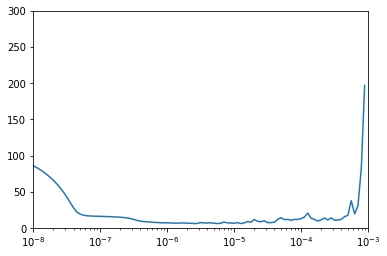

In [16]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [17]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = get_model()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 2s 51ms/step - loss: 86.0873 - mae: 86.5488
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 80.6344 - mae: 81.1658
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 74.7196 - mae: 74.9957
Epoch 4/100
31/31 [==============================] - 0s 16ms/step - loss: 68.1323 - mae: 68.3964
Epoch 5/100
31/31 [==============================] - 1s 17ms/step - loss: 61.0140 - mae: 61.4415
Epoch 6/100
31/31 [==============================] - 0s 16ms/step - loss: 53.7454 - mae: 54.1803
Epoch 7/100
31/31 [==============================] - 1s 17ms/step - loss: 46.6294 - mae: 46.9459
Epoch 8/100
31/31 [==============================] - 1s 16ms/step - loss: 39.6962 - mae: 40.1075
Epoch 9/100
31/31 [==============================] - 1s 16ms/step - loss: 33.5258 - mae: 33.9432
Epoch 10/100
31/31 [==============================] - 0s 16ms/step - loss: 27.9080 - mae: 28.3429
Epoch 11/100
31/31 [=========

31/31 [==============================] - 0s 16ms/step - loss: 20.8174 - mae: 21.1173
Epoch 86/100
31/31 [==============================] - 1s 16ms/step - loss: 19.1283 - mae: 19.6197
Epoch 87/100
31/31 [==============================] - 0s 16ms/step - loss: 17.5238 - mae: 18.0398
Epoch 88/100
31/31 [==============================] - 1s 16ms/step - loss: 16.7186 - mae: 17.2428
Epoch 89/100
31/31 [==============================] - 1s 17ms/step - loss: 16.8888 - mae: 17.2779
Epoch 90/100
31/31 [==============================] - 0s 16ms/step - loss: 17.0468 - mae: 17.4073
Epoch 91/100
31/31 [==============================] - 1s 17ms/step - loss: 19.1999 - mae: 19.6949
Epoch 92/100
31/31 [==============================] - 0s 16ms/step - loss: 17.1417 - mae: 17.6127
Epoch 93/100
31/31 [==============================] - 1s 16ms/step - loss: 22.3337 - mae: 22.9354
Epoch 94/100
31/31 [==============================] - 0s 16ms/step - loss: 24.3539 - mae: 24.6409
Epoch 95/100
31/31 [=============

In [24]:
history.history['mae']

[86.54883,
 81.16578,
 74.99571,
 68.396416,
 61.441463,
 54.18028,
 46.945934,
 40.107452,
 33.943237,
 28.342905,
 23.29815,
 19.198828,
 16.53564,
 15.241968,
 14.49186,
 14.114143,
 13.920067,
 13.791586,
 13.702266,
 13.594165,
 13.502944,
 13.4059305,
 13.306355,
 13.206418,
 13.105974,
 13.010011,
 12.879523,
 12.745638,
 12.616319,
 12.468443,
 12.290677,
 12.116358,
 11.910765,
 11.678316,
 11.436185,
 11.134653,
 10.8079195,
 10.396495,
 9.995565,
 9.540518,
 9.102586,
 8.701185,
 8.161452,
 7.8496284,
 7.7412925,
 7.358691,
 7.379812,
 6.7701,
 6.602336,
 7.203797,
 6.718302,
 6.536076,
 6.413718,
 6.9231033,
 7.057571,
 6.8551693,
 7.5738106,
 6.6387153,
 6.4591403,
 8.247047,
 6.6503696,
 7.389478,
 7.25314,
 9.497469,
 8.795948,
 7.111686,
 10.657245,
 8.110554,
 9.014168,
 10.071595,
 8.365887,
 10.941782,
 16.378002,
 8.931679,
 11.913074,
 16.57379,
 12.390719,
 15.833512,
 11.576161,
 16.215586,
 15.935399,
 16.285488,
 20.950987,
 17.400562,
 21.11734,
 19.619728,
 1

<Figure size 432x288 with 0 Axes>

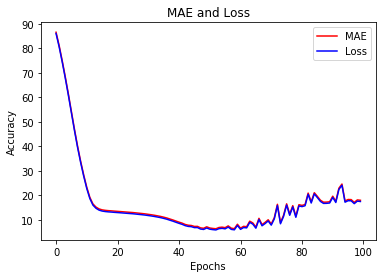

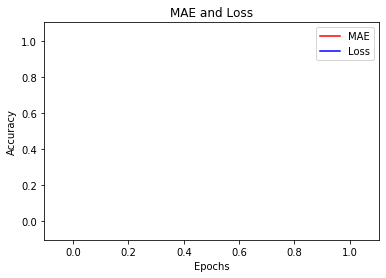

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()